In [1]:
import numpy as np
import pandas as pd
from sklearn import svm, metrics
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import os
from config import *
from data_loader import *

from torchtext import data
from torchtext import datasets as nlp_dset
import nltk
from torchtext.vocab import Vectors
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
SEED = 2000
embedding_dim = 200
device_idx = 0
GPU = False
if GPU:
    device = torch.device("cuda:"+str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cpu


### Loading Data

In [3]:
dl = Data_Loader()
train_df = dl.get_data()
# dl.save_csv()

/Users/shawngung/Desktop/offEval/data_loader.py:12: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  self.dataframe = pd.DataFrame.from_csv(file, sep='\t', header=0)
[nltk_data] Downloading package punkt to /Users/shawngung/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shawngung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def transfrom_for_scikit(task_header, text_field, label_field, embedding, train):
    """
    task_header is one of subtask_a, subtask_b, subtask_c
    """
    tokenised_train = [example.cleaned_s for example in train]
    labels = np.array(
      label_field.process(
          [getattr(example, task_header) for example in train]
      )
    )

    word_idxs = text_field.process(tokenised_train)
    embeddings = torch.mean(embedding(word_idxs).detach(), dim=1)
    return embeddings.numpy(), labels

In [5]:
class textCNNGloVe(nn.Module):    
    def __init__(self, vocab, embedding_dim,hidden_dim = 100, dropout = 0.5, num_classes=2):
        super(textCNNGloVe, self).__init__()
        drop_prob = dropout
        kernel_nums = [100, 100, 100]
        kernel_sizes = [3, 4, 5]
        
        self.drop = nn.Dropout(drop_prob)
        
        self.vocab = vocab
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.embedding.weight.data.copy_(vocab.vectors)
        
        self.convs = nn.ModuleList(
            [nn.Conv1d(embedding_dim, kn, ks)
             for kn, ks in zip(kernel_nums, kernel_sizes)])
        self.fc = nn.Linear(sum(kernel_nums), hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(hidden_dim, 1 if num_classes == 2 else num_classes)

    def forward(self, x):
        # embed
        e = self.drop(self.embedding(x))  # [b,msl]->[b,msl,e]

        # conv and pool, [b,msl,e]->[b,h,msl]
        e = e.transpose(1, 2)  # [b,msl,e]->[b,e,msl]
        ps = []
        for conv in self.convs:
            c = conv(e)  # [b,e,msl]->[b,h,msl-k]
            p = F.max_pool1d(c, kernel_size=c.size(-1)).squeeze(-1)  # [b,h]
            ps.append(p)
        p = torch.cat(ps, dim=1)  # [b,h]

        # feed-forward, [b,h]->[b]
        f = self.drop(self.fc(p))
        logits = self.out(f)# b x mul_class
        return logits

In [6]:
def check_accuracy(task_header, loader, model, conf=False):
    """
    Note at the moment this function assumes the batch size is equal to the 
    number of data in the loader when calculating the confusion matrix
    """
    num_correct = 0
    num_samples = 0
    
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            x, y = batch.cleaned_s, getattr(batch, task_header)
            , getattr(batch, task_header)
            y = y.view(-1, 1)
                
            x = x.to(device=device, dtype=torch.long)  # move to  GPU
            y = y.to(device=device, dtype=torch.long)
            
            if task_header == 'subtask_c':
              pred_prob = F.softmax(model(x), dim=1)
              pred_1 = torch.argmax(pred_prob, dim=1).view(-1, 1)
            else:
              pred_prob = torch.sigmoid(model(x))
              pred_1 = (pred_prob > 0.5).type(torch.long)
              
            num_correct += (pred_1 == y).sum()
            num_samples += pred_prob.size(0)
            
            # move to CPU to prevent memory overflow and calculate metrics
            x = x.to(device="cpu", dtype=torch.long)
            y = y.to(device="cpu", dtype=torch.long).numpy()
            pred_1 = pred_1.to(device="cpu", dtype=torch.long).numpy()
            
            
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        if conf:
            print(metrics.confusion_matrix(y, pred_1))
            print(metrics.classification_report(y, pred_1))

In [7]:
def train_helper(task_header, model, optimizer, train_loader, 
               valid_loader, epochs=1, loss_fn=F.binary_cross_entropy_with_logits, print_every=50):
    """
    Train a model
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to GPU
    
    training_losses = []
    validation_losses = []
    try:
        for epoch in range(epochs):
            print("Epoch:", epoch)
            total_loss = 0
            for batch_idx, batch in enumerate(train_loader):

                model.train()  # put model to training mode
                
                inputs, targets = batch.cleaned_s, getattr(batch, task_header)
                
                x = inputs.to(device=device, dtype=torch.long)  # move to device, e.g. GPU
                y = targets.to(device=device, dtype=torch.long if task_header == 'subtask_c' else torch.float) #this should be a float cross entropy
                #x = inputs
                #y = targets
                logits = model(x)
                
                # When using cross_entropy the targets need to have a shape (N,)
                # However, for BCEWithLogits they just need
                # to have the same shape as the logits
                loss = loss_fn(logits, y.view(-1,) if isinstance(loss_fn, nn.CrossEntropyLoss) else y.view(-1, 1))
                # Zero out all of the gradients for the variables which the optimizer
                # will update.
                optimizer.zero_grad()

                # This is the backwards pass: compute the gradient of the loss with
                # respect to each  parameter of the model.
                loss.backward()

                # Actually update the parameters of the model using the gradients
                # computed by the backwards pass.
                optimizer.step()

                x = x.to(device="cpu", dtype=torch.long)  # move to CPU to prevent memory overflow
                y = y.to(device="cpu", dtype=torch.long)

                total_loss += loss.detach().item()
                
                if batch_idx % print_every == 0:
                    print('Iteration %d, loss = %.4f' % (batch_idx, loss.item()))
            
            training_losses.append(total_loss/len(train_iterator))
            print()
            print("Validation Accuracy:")
            check_accuracy(task_header, valid_loader, model, conf=True)
            valid_loss = check_loss(task_header, valid_loader, model, loss_fn)
            validation_losses.append(valid_loss)
            print()
        return training_losses, validation_losses
    except Exception as e:
        #Attempt to prevent GPU memory overflow by transferring model back to cpu
        #model = model.to(device="cpu")
        raise e

In [8]:
def check_loss(task_header, loader, model, loss_fn):
    model.eval()
    with torch.no_grad():
        loss = 0
        for idx, batch in enumerate(loader):
            x, y = batch.cleaned_s, getattr(batch, task_header)

            x = x.to(device=device, dtype=torch.long) 
            y = y.to(device=device, dtype=torch.long if task_header == 'subtask_c' else torch.float)

            logits = model(x)

            loss += loss_fn(logits, y.view(-1,) if isinstance(loss_fn, nn.CrossEntropyLoss) else y.view(-1, 1))

    return loss/len(loader)

### Task A

In [9]:
#Create fields
BATCH_SIZE = 128
fix_length = 48
TEXT = data.Field(
    sequential=True, use_vocab=True, lower=True,
    tokenize=nltk.word_tokenize, batch_first=True,
    is_target=False, fix_length=fix_length)

LABEL = data.LabelField(sequential=False, use_vocab=True, batch_first = True,is_target=True)
ID = data.LabelField(sequential=False, use_vocab=False, batch_first=True)

data_fields = {
                "cleaned_s": ('cleaned_s', TEXT),
                'subtask_a': ('subtask_a',LABEL),
                'subtask_b': ('subtask_b',LABEL),
                'subtask_c': ('subtask_c',LABEL),
              }


train = data.TabularDataset(os.path.join(DATA_DIR,PROCESSED_DATA_FILE), format='csv', fields = 
                            data_fields)

train, valid = train.split(split_ratio=0.9, random_state=random.seed(SEED))

print(f'Train size: {len(train)}')
print(f'Validation size: {len(valid)}')

vectors = Vectors(name='glove.6B.200d.txt', cache=GLOVE_DIR)
#Now build vocab (using only the training set)
TEXT.build_vocab(train, vectors=vectors) #USE "glove.840B.300d" or glove.twitter.27B.200d


LABEL.build_vocab(train.subtask_a)

output_dim = len(LABEL.vocab)

#Create iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                        batch_sizes=(BATCH_SIZE, len(valid)),  
                        sort_key=lambda x: len(x.cleaned_s))

Train size: 11916
Validation size: 1324


In [10]:
print('first cleaned_s :', train[100].cleaned_s)
print('first label :', train[100].subtask_a)
# print(TEXT.vocab.stoi) # word to index
# print(LABEL.vocab.stoi) # label to index

first cleaned_s : ['thats', 'call', 'gun', 'control']
first label : NOT


In [13]:
embedding_dim = 200
lr = 0.00025

model = textCNNGloVe(TEXT.vocab,
                              embedding_dim,
                              num_classes = 2
                              )

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss()

t_losses, v_losses = train_helper('subtask_a',
                                  model,
                                  optimizer,
                                  loss_fn = loss_fn,
                                  epochs = 10,
                                  train_loader=train_iterator,
                                  valid_loader=valid_iterator)

Epoch: 0
Iteration 0, loss = 0.6676
Iteration 50, loss = 0.6180

Validation Accuracy:
Got 977 / 1324 correct (73.79)
[[878  27]
 [320  99]]
              precision    recall  f1-score   support

           0       0.73      0.97      0.83       905
           1       0.79      0.24      0.36       419

   micro avg       0.74      0.74      0.74      1324
   macro avg       0.76      0.60      0.60      1324
weighted avg       0.75      0.74      0.69      1324


Epoch: 1
Iteration 0, loss = 0.6081
Iteration 50, loss = 0.5294

Validation Accuracy:
Got 1029 / 1324 correct (77.72)
[[860  45]
 [250 169]]
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       905
           1       0.79      0.40      0.53       419

   micro avg       0.78      0.78      0.78      1324
   macro avg       0.78      0.68      0.69      1324
weighted avg       0.78      0.78      0.75      1324


Epoch: 2
Iteration 0, loss = 0.5304
Iteration 50, loss = 0.5219

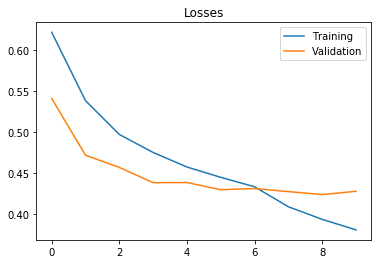

In [14]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()

ax1.plot(t_losses, label='Training')
ax1.plot(v_losses, label='Validation')

ax1.set_title('Losses')
ax1.legend()

plt.show()

### Task B

In [15]:
#Create fields
BATCH_SIZE = 128
fix_length = 48
TEXT = data.Field(
    sequential=True, use_vocab=True, lower=True,
    tokenize=nltk.word_tokenize, batch_first=True,
    is_target=False, fix_length=fix_length)

LABEL = data.LabelField(sequential=False, use_vocab=True, batch_first = True,is_target=True)

data_fields = {
                "cleaned_s": ('cleaned_s', TEXT),
                'subtask_a': ('subtask_a',LABEL),
                'subtask_b': ('subtask_b',LABEL),
              }


train = data.TabularDataset(os.path.join(DATA_DIR,PROCESSED_DATA_FILE),
                            format='csv',
                            fields=data_fields,
                            filter_pred=lambda d: d.subtask_a == 'OFF')

train, valid = train.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f'Train size: {len(train)}')
print(f'Validation size: {len(valid)}')

#Now build vocab (using only the training set)
# This is where tokenization is performed on train

vectors = Vectors(name='glove.6B.200d.txt', cache=GLOVE_DIR)
#Now build vocab (using only the training set)
TEXT.build_vocab(train, vectors=vectors) #USE "glove.840B.300d" or glove.twitter.27B.200d
LABEL.build_vocab(train.subtask_b)

output_dim = len(LABEL.vocab)

print(LABEL.vocab.stoi)

#Create iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                        batch_sizes=(BATCH_SIZE, len(valid)),  
                        sort_key=lambda x: len(x.cleaned_s))

Train size: 3520
Validation size: 880
defaultdict(<function _default_unk_index at 0x1a2cd510d0>, {'TIN': 0, 'UNT': 1})


In [16]:
embedding_dim = 200
lr = 0.00025

model = textCNNGloVe(TEXT.vocab,
                              embedding_dim,
                              num_classes = 2
                              )

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss()

t_losses, v_losses = train_helper('subtask_b',
                                  model,
                                  optimizer,
                                  loss_fn = loss_fn,
                                  epochs = 20,
                                  train_loader=train_iterator,
                                  valid_loader=valid_iterator)

Epoch: 0
Iteration 0, loss = 0.7399

Validation Accuracy:
Got 785 / 880 correct (89.20)
[[785   0]
 [ 95   0]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       785
           1       0.00      0.00      0.00        95

   micro avg       0.89      0.89      0.89       880
   macro avg       0.45      0.50      0.47       880
weighted avg       0.80      0.89      0.84       880



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Epoch: 1
Iteration 0, loss = 0.3340

Validation Accuracy:
Got 785 / 880 correct (89.20)
[[785   0]
 [ 95   0]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       785
           1       0.00      0.00      0.00        95

   micro avg       0.89      0.89      0.89       880
   macro avg       0.45      0.50      0.47       880
weighted avg       0.80      0.89      0.84       880


Epoch: 2
Iteration 0, loss = 0.3796

Validation Accuracy:
Got 785 / 880 correct (89.20)
[[785   0]
 [ 95   0]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       785
           1       0.00      0.00      0.00        95

   micro avg       0.89      0.89      0.89       880
   macro avg       0.45      0.50      0.47       880
weighted avg       0.80      0.89      0.84       880


Epoch: 3
Iteration 0, loss = 0.3272

Validation Accuracy:
Got 785 / 880 correct (89.20)
[[785   0]
 [ 95   0]]
          

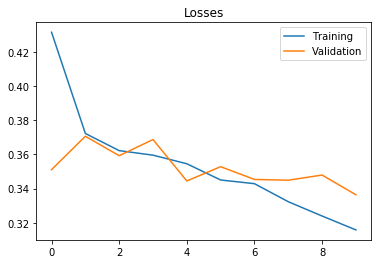

In [17]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()

ax1.plot(t_losses, label='Training')
ax1.plot(v_losses, label='Validation')

ax1.set_title('Losses')
ax1.legend()

plt.show()

### Task C

In [18]:
#Create fields
BATCH_SIZE = 128
TEXT = data.Field(
    sequential=True, use_vocab=True, lower=True,
    tokenize=nltk.word_tokenize, batch_first=True,
    is_target=False)

LABEL = data.LabelField(sequential=False, use_vocab=True, batch_first = True,is_target=True)


data_fields = {
                "cleaned_s": ('cleaned_s', TEXT),
                'subtask_a': ('subtask_a',LABEL),
                'subtask_b': ('subtask_b',LABEL),
                'subtask_c': ('subtask_c',LABEL)
              }

train = data.TabularDataset(os.path.join(DATA_DIR,PROCESSED_DATA_FILE),
                            format='csv',
                            fields=data_fields,
                            filter_pred=lambda d: d.subtask_a == 'OFF' and d.subtask_b == 'TIN')

train, valid = train.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f'Train size: {len(train)}')
print(f'Validation size: {len(valid)}')

#Now build vocab (using only the training set)

vectors = Vectors(name='glove.6B.200d.txt', cache=GLOVE_DIR)
#Now build vocab (using only the training set)
TEXT.build_vocab(train, vectors=vectors) #USE "glove.840B.300d" or glove.twitter.27B.200d
LABEL.build_vocab(train.subtask_c)

output_dim = len(LABEL.vocab)

print(LABEL.vocab.stoi)

#Create iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                        batch_sizes=(BATCH_SIZE, len(valid)),  
                        sort_key=lambda x: len(x.cleaned_s))

Train size: 3101
Validation size: 775
defaultdict(<function _default_unk_index at 0x1a2cd510d0>, {'IND': 0, 'GRP': 1, 'OTH': 2})


In [20]:
embedding_dim = 200
lr = 0.00025

model = textCNNGloVe(TEXT.vocab,
                              embedding_dim,
                              num_classes = 3
                              )

optimizer = optim.Adam(model.parameters(), lr,weight_decay=0.0054326444080709255)
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1.6, 3.7, 8.4], device=device))

t_losses, v_losses = train_helper('subtask_c',
                                  model,
                                  optimizer,
                                  loss_fn = loss_fn,
                                  epochs = 20,
                                  train_loader=train_iterator,
                                  valid_loader=valid_iterator)

Epoch: 0
Iteration 0, loss = 1.1318

Validation Accuracy:
Got 415 / 775 correct (53.55)
[[226 190  32]
 [ 37 175  23]
 [ 24  54  14]]
              precision    recall  f1-score   support

           0       0.79      0.50      0.61       448
           1       0.42      0.74      0.54       235
           2       0.20      0.15      0.17        92

   micro avg       0.54      0.54      0.54       775
   macro avg       0.47      0.47      0.44       775
weighted avg       0.61      0.54      0.54       775


Epoch: 1
Iteration 0, loss = 1.0760

Validation Accuracy:
Got 449 / 775 correct (57.94)
[[258 190   0]
 [ 43 191   1]
 [ 26  66   0]]
              precision    recall  f1-score   support

           0       0.79      0.58      0.67       448
           1       0.43      0.81      0.56       235
           2       0.00      0.00      0.00        92

   micro avg       0.58      0.58      0.58       775
   macro avg       0.41      0.46      0.41       775
weighted avg       0.59 


Epoch: 16
Iteration 0, loss = 0.7432

Validation Accuracy:
Got 479 / 775 correct (61.81)
[[311  86  51]
 [ 44 144  47]
 [ 31  37  24]]
              precision    recall  f1-score   support

           0       0.81      0.69      0.75       448
           1       0.54      0.61      0.57       235
           2       0.20      0.26      0.22        92

   micro avg       0.62      0.62      0.62       775
   macro avg       0.51      0.52      0.51       775
weighted avg       0.65      0.62      0.63       775


Epoch: 17
Iteration 0, loss = 0.7720

Validation Accuracy:
Got 481 / 775 correct (62.06)
[[312  88  48]
 [ 48 145  42]
 [ 31  37  24]]
              precision    recall  f1-score   support

           0       0.80      0.70      0.74       448
           1       0.54      0.62      0.57       235
           2       0.21      0.26      0.23        92

   micro avg       0.62      0.62      0.62       775
   macro avg       0.52      0.52      0.52       775
weighted avg       0.

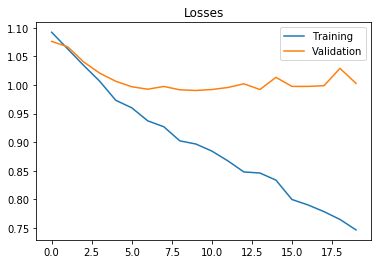

In [21]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()

ax1.plot(t_losses, label='Training')
ax1.plot(v_losses, label='Validation')

ax1.set_title('Losses')
ax1.legend()

plt.show()